## COMP5328 - Advanced Machine Learning
## Assignment 1: Non-negative Matrix Factorization
----------------------------------------------------------------------------------------

**(Semester 2, 2025)**

In this ipython notebook, we provide some example code for assignment1.
+ Load Data.
    - ORL dataset.
    - Extended YaleB dataset.
    - AR dataset (**optional**).
+ Perform Evaluation.
   - Relative Reconstruction Errors.
   - Accuracy, NMI (**optional**).

Lecturer: Tongliang Liu.

**Note: All datasets can be used only for this assignment and you are not allowed to distribute these datasets. If you want to use AR dataset, you need to apply it by yourself (we do not provide AR dataset due to the problem of license, please find more details in http://www2.ece.ohio-state.edu/~aleix/ARdatabase.html).**

In [ ]:
# Common
import os
import pandas as pd
import numpy as np
import json
import time
from PIL import Image
from collections import Counter, defaultdict

# Ploting
import matplotlib.pyplot as plt

# Evaluation 
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score

#Experiment
from joblib import Parallel, delayed
import traceback

# Notebook variables
seed = 0
rng = np.random.default_rng(seed)

# Folder locations of datasets
orl_data_location = 'data/ORL'
yaleB_data_location = 'data/CroppedYaleB'

In [ ]:
datasets = ["ORL", "YALE"]
methods  = ["Frobenius", "L21"]

sp_noise_combos = [
    (0.01, 0.5), 
    (0.05, 0.3), 
    (0.1, 0.5),   
    (0.1, 0.7),  
    (0.2, 0.5),   
    (0.3, 0.3),  
    (0.3, 0.7),   
]

## 1. Load Dataset

### 1.0 Data Folder

In [ ]:
# Path to your dataset zip stored in Drive
zip_path = "data.zip"

# Unzip file
#!unzip -o -q "$zip_path" 

In [ ]:
# base hyperparameter grid
base = {
    "dataset": "ORL",             # "ORL" or "YALE"
    "normalization": "per_image", # "none" or "per_image" or "global"
    "noise_type": "salt_pepper",  # type of adding noise
    "noise_p": 0.05,
    "noise_r": 0.5,
    "nmf_type": "Frobenius",      # "Frobenius" or "L21"
    "rank": "auto",               # shared dimension between W and H. Set as an int or as "auto" to be num of classes in Y
    "max_iterations": 1000,
    "tol": 1e-4,                  # Tolerance, allows for early stopping
    "seed": 0,                    # the seeding for RNG. Allows consistent replication
    "reduce_ORL": 2,              # Reduction factor. ORL pics are smaller so maybe reduce less
    "reduce_YALE": 3,             # YALE pics are larger so can reduce more
    "epsilon": 1e-12,
}

In [140]:
# The structure of data folder.
!ls -l data

total 0
drwxrwxrwx@ 41 jamie.saunders  staff  1312 Oct  4 14:21 CroppedYaleB
drwx------@ 44 jamie.saunders  staff  1408 Oct  4 14:37 ORL


### 1.1 Load ORL Dataset and Extended YaleB Dataset.
+ ORL dataset contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). The size of each image is 92x112 pixels, with 256 grey levels per pixel. To further reduce the computation complexity, you can resize all images to 30x37 pixels.

+ Extended YaleB dataset contains 2414 images of 38 human subjects under 9 poses and 64 illumination conditions. All images are manually aligned, cropped, and then resized to 168x192 pixels. To further reduce the computation complexity, you can resize all images to 42x48 pixels.

In [ ]:
def load_data(root, reduce=2, normalization="per_image", eps=1e-12):
    """
    Load ORL or Extended YaleB dataset to numpy array.

    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.
        normalisation: context for which to apply normalisation
        epis:
    """
    images, labels = [], []
    height, width = 0, 0

    for i, person in enumerate(sorted(os.listdir(root))):

        if not os.path.isdir(os.path.join(root, person)):
            continue

        for fname in os.listdir(os.path.join(root, person)):

            # Remove background images in Extended YaleB dataset.
            if fname.endswith('Ambient.pgm'):
                continue

            if not fname.endswith('.pgm'):
                continue

            # load image.
            img = Image.open(os.path.join(root, person, fname))
            img = img.convert('L') # grey image.


            # reduce computation complexity.
            img = img.resize([s//reduce for s in img.size])

            # save the height/width after resizing
            if (height == 0 or width == 0):
              height = img.size[1]
              width = img.size[0]

            img = np.asarray(img, dtype=np.float32)

            # normalzation per image
            if normalization == "per_image":
              img = (img - img.min()) / (img.max() - img.min() + eps)

            img = img.reshape((-1,1))

            # collect data and label.
            images.append(img)
            labels.append(i)

    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)

    # normalize globally
    if normalization == "global":
      images = images.astype(np.float32)
      images = images / 255.0 # normalizing them


    return images, labels, height, width

In [ ]:
# randomly select 90%
def make_stratified_subset(V, Y, V_hat, frac=0.9, seed=0):
  """
  Calculates the H update and W update steps for L21 NMF

  Args:
    V: Original matrix
    Y: Target labels
    V_hat:
    frac:
    seed:
  """
  
  rng = np.random.default_rng(seed)
  labels = np.unique(Y)
  idx_trimmed = []
  # print(labels)
  for cls in labels:
    cls_idx = np.where(Y == cls)[0]
    amount_to_keep = int(frac * len(cls_idx))
    chosen = rng.choice(cls_idx, size=amount_to_keep, replace=False)
    idx_trimmed.extend(chosen)
  idx_trimmed = np.array(idx_trimmed)
  V_trimmed = V[:, idx_trimmed]
  Y_trimmed = Y[idx_trimmed]
  V_hat_trimmed = V_hat[:, idx_trimmed]
  return V_trimmed, Y_trimmed, V_hat_trimmed

### 1.2 Generate and Apply Noise to Dataset
+ ORL dataset contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). The size of each image is 92x112 pixels, with 256 grey levels per pixel. To further reduce the computation complexity, you can resize all images to 30x37 pixels.

+ Extended YaleB dataset contains 2414 images of 38 human subjects under 9 poses and 64 illumination conditions. All images are manually aligned, cropped, and then resized to 168x192 pixels. To further reduce the computation complexity, you can resize all images to 42x48 pixels.

In [ ]:
# salt and pepper noise
def add_sp_noise(V_hat, p=0, r=0, rng=None):
  """
  Apply salt and pepper noise to an image dataset.

  Args:
    V_hat: dataset to create a copy of with noise applied
    p: hyperparameter to control the noise leve
    r: hyperparameter to control the ratio of white (salt) and black (pepper) pixels
    rng: 
  """
  if rng is None:
    rng = np.random.default_rng()

  m, n = V_hat.shape # n images, each has m pixels in a flat vector

  V_noise = V_hat.copy()

  for i in range(n): #iterate through each image
    for j in range(m): #iterate through each pixel
      if rng.random() < p: #we modify the pixel
        if rng.random() < r:
          V_noise[j, i] = 1.0 # turn the pixel white
        else:
          V_noise[j, i] = 0.0 # turn the pixel black

  return V_noise


# block occlusion noise
def add_block_noise(V_hat, h, w, log_return=False):
  """
  Apply block occlusion noise to an image dataset.

  Args:
    V_hat: dataset to create a copy of with noise applied
    r: hyperparameter to control the ratio of white (salt) and black (pepper) pixels
    log_return: boolean to drive the returning of logging details
  """
  m, n = V_hat.shape # n images, each has m pixels in a flat vector
  V_noise = V_hat.copy()
  min_square_size = m
  max_square_size = 0
  noise_log = []
  i = 0
  ii = 0

  for img in range(n): #iterate through each image
    square_width=np.random.uniform(.2, .4) * w
    square_height=np.random.uniform(.2, .4) * h
    square_size = square_width*square_height
    min_square_size = min(min_square_size, square_width)
    max_square_size = max(max_square_size, square_size)
    # Random top-left corner, making sure the square fits in the image
    x = np.random.randint(0, w - square_width)
    y = np.random.randint(0, h - square_height)

    j = x + y * w 

    noise_log.append({"img":img, "start_index":j, "start_point":f"{x}-{y}", "square_dimensions":f"{square_width}x{square_height}", "square_size":square_size})
    print(noise_log)
    # Set the square to white (255)
    while i < square_width:
      while ii < square_height:
        V_noise[j+ii][img] = 1
        ii = ii + 1
        
      i = i + 1
      ii = 0
      j = (i + y) * w + x
    i = 0
    ii = 0
    
  if log_return:
    print(f"Dimenstions (V_hat m): {m}")
    print(f"Images (V_hat n): {n}")
    print(f"Image width: {w}")
    print(f"Image height: {h}")
    print(f"min square size: {min_square_size}")
    print(f"max square size: {max_square_size}")
    print(json.dumps(noise_log, indent=4))

  return V_noise, noise_log

### 1.3 Noise Demonstration
Display a random sample of the original images alongside the images post noise generation

In [185]:
v_noise_block, noise_log = add_block_noise(V_hat, h, w)


[{'img': 0, 'start_index': 1533, 'start_point': '61-16', 'square_dimensions': '28.85591693132649x41.36226248374823', 'square_size': 1193.546010322761}]
[{'img': 0, 'start_index': 1533, 'start_point': '61-16', 'square_dimensions': '28.85591693132649x41.36226248374823', 'square_size': 1193.546010322761}, {'img': 1, 'start_index': 6758, 'start_point': '42-73', 'square_dimensions': '18.640761056340523x28.492081608357346', 'square_size': 531.1140852591436}]
[{'img': 0, 'start_index': 1533, 'start_point': '61-16', 'square_dimensions': '28.85591693132649x41.36226248374823', 'square_size': 1193.546010322761}, {'img': 1, 'start_index': 6758, 'start_point': '42-73', 'square_dimensions': '18.640761056340523x28.492081608357346', 'square_size': 531.1140852591436}, {'img': 2, 'start_index': 7494, 'start_point': '42-81', 'square_dimensions': '20.00199182371776x26.005272221644447', 'square_size': 520.1572423508868}]
[{'img': 0, 'start_index': 1533, 'start_point': '61-16', 'square_dimensions': '28.8559

IndexError: index 10359 is out of bounds for axis 0 with size 10304

In [178]:
V_hat, Y_hat, h, w = load_data(root=orl_data_location, normalization='per_image')

dataset = 'ORL'
noise_types = ['salt_pepper', 'block']
num_imgs = 5
rows, cols = num_imgs, 3   # Original + two noise types

fig, axes = plt.subplots(rows, cols, figsize=(9, 20))

start_ind = np.random.randint(0, len(V_hat[0])-num_imgs)
end_ind = start_ind + num_imgs 

for i, ind in enumerate(range(start_ind, end_ind)):
    # --- Original ---
    ax = axes[i, 0]
    ax.imshow(V_hat[:, ind].reshape(h, w), cmap=plt.cm.gray)
    ax.set_title('Original', fontsize=10, pad=2, y=1.05)

    # --- Salt & Pepper noise ---
    v_noise_sp = add_sp_noise(V_hat, sp_noise_combos[i][0], sp_noise_combos[i][1])
    ax = axes[i, 1]
    ax.imshow(v_noise_sp[:, ind].reshape(h, w), cmap=plt.cm.gray)
    ax.set_title(f'Salt & Pepper: p={sp_noise_combos[i][0]}, r = {sp_noise_combos[i][1]}', fontsize=10, pad=2, y=1.05)

    # --- Block noise ---
    v_noise_block, noise_log = add_block_noise(V_hat, h, w)
    ax = axes[i, 2]
    ax.imshow(v_noise_block[:, ind].reshape(h, w), cmap=plt.cm.gray)
    ax.set_title(f'Block: start_point={noise_log[ind]['start_point']}, square_dimensions= {noise_log[ind]['square_dimensions']}', fontsize=10, pad=2, y=1.05)

fig.suptitle(f"Noise Type Comparison: {dataset}", fontsize=16, y=0.94)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


SyntaxError: f-string: unmatched '[' (2107278903.py, line 29)

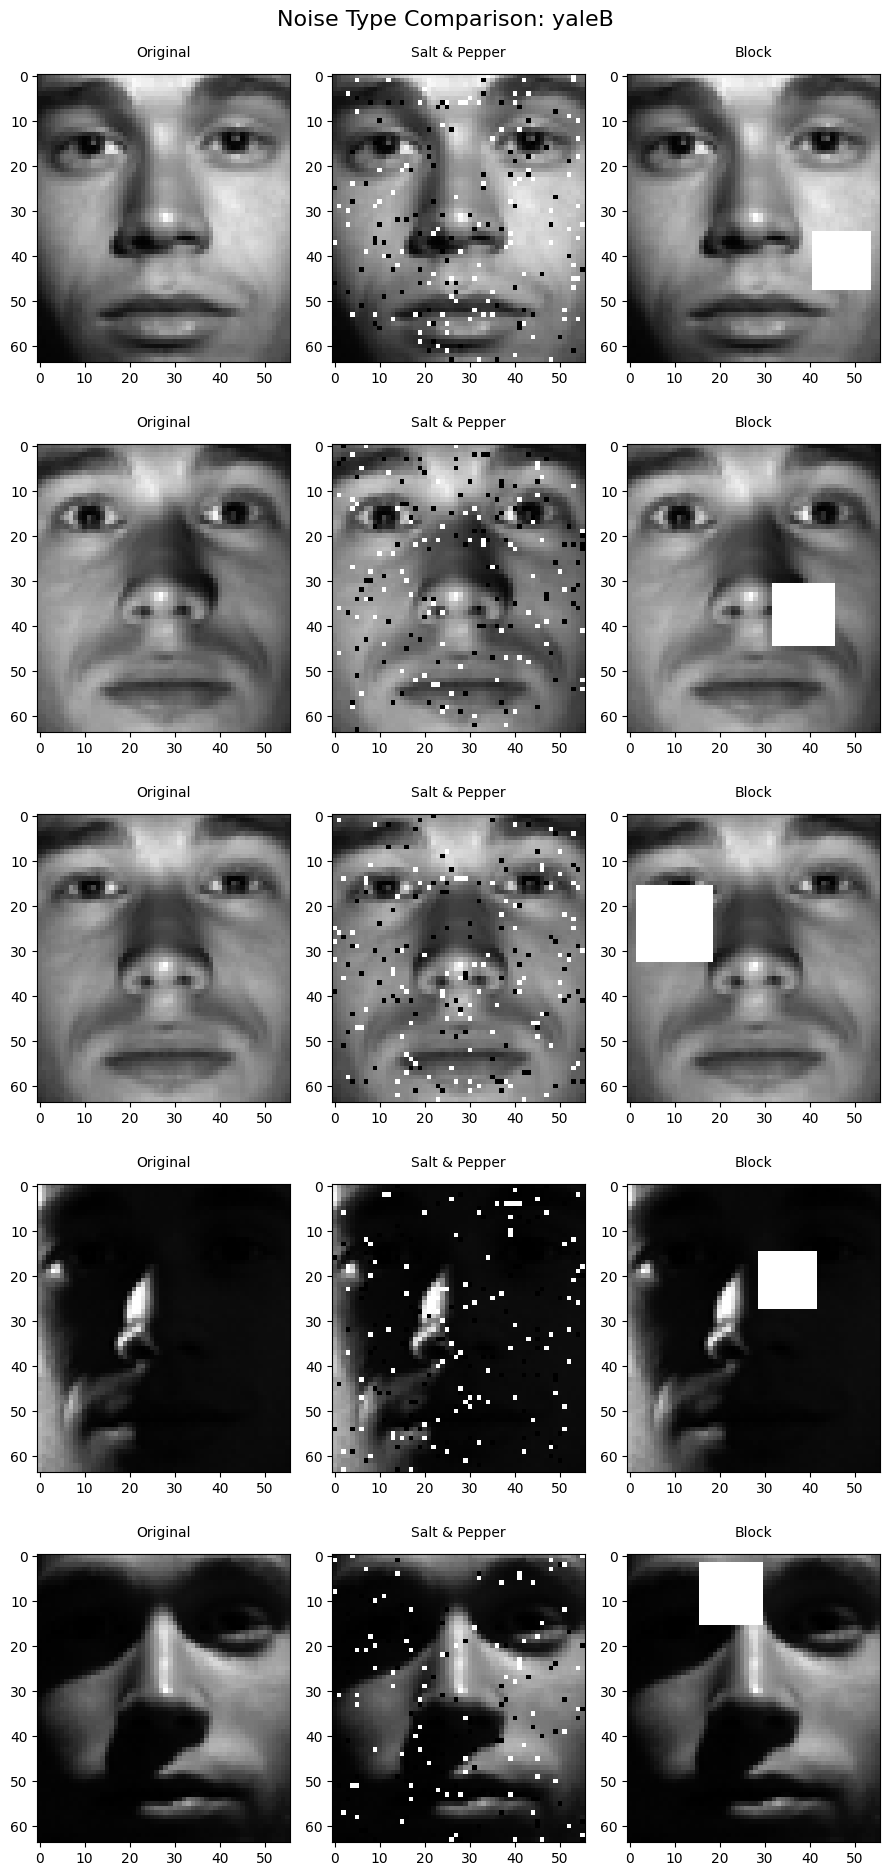

In [143]:

V_hat, Y_hat, h, w = load_data(root=yaleB_data_location, reduce=config["reduce_YALE"], normalization=config["normalization"]) 
dataset = 'yaleB'
noise_types = ['salt_pepper', 'block']
num_imgs = 5
rows, cols = num_imgs, 3   # Original + two noise types
fig, axes = plt.subplots(rows, cols, figsize=(9, 20))

start_ind = start_ind = np.random.randint(0, len(V_hat[0])-num_imgs)
end_ind = start_ind + num_imgs 

for i, ind in enumerate(range(start_ind, end_ind)):
    # --- Original ---
    ax = axes[i, 0]
    ax.imshow(V_hat[:, ind].reshape(h, w), cmap=plt.cm.gray)
    ax.set_title('Original', fontsize=10, pad=2, y=1.05)

    # --- Salt & Pepper noise ---
    v_noise_sp = add_sp_noise(V_hat, .05, 0.5)
    ax = axes[i, 1]
    ax.imshow(v_noise_sp[:, ind].reshape(h, w), cmap=plt.cm.gray)
    ax.set_title('Salt & Pepper', fontsize=10, pad=2, y=1.05)

    # --- Block noise ---
    v_noise_block = add_block_noise(V_hat, h, w)
    ax = axes[i, 2]
    ax.imshow(v_noise_block[:, ind].reshape(h, w), cmap=plt.cm.gray)
    ax.set_title('Block', fontsize=10, pad=2, y=1.05)

fig.suptitle(f"Noise Type Comparison: {dataset}", fontsize=16, y=0.94)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


---------------------------


## 2. Evaluation Metrics


### 2.1 Relative Reconstruction Errors (RRE)

To compare the robustness of different NMF algorithms, you can use the ```relative reconstruction errors```. Let $V$ denote the contaminated dataset (by adding noise), and $\hat{V}$
 denote the clean dataset. Let $W$ and $H$ denote the factorization results on $V$, the ``relative reconstruction errors`` then can be defined as follows:
 \begin{equation}
    RRE = \frac{ \| \hat{V} - WH \|_F }{ \| \hat{V} \|_F}.
\end{equation}


In [144]:
# Defining NMF Funtions

# FSE method
def frobenius_squared_error(V, W, H):
  """
  Return frobenious squared reconstruction error

  Args:
    V: Original matrix
    W: Basis matrix
    H: Encoding matrix
  """
  WH = W @ H
  return np.sum((V - WH) ** 2)

def rre_fse(V_hat, W, H, eps=1e-12): 
  """
  Return relative reconstruction forbenious error

  Args:
    V: Original matrix (without noise)
    W: Basis matrix
    H: Encoding matrix
    eps:
  """
  WH = W @ H
  FE = np.linalg.norm( V_hat - WH, ord='fro')
  denom = np.linalg.norm(V_hat, ord='fro')
  RRE = FE / (denom + eps)
  return RRE

def fse_mur(V, W, H, max_iterations, tol, eps=1e-12, verbosity=1):
  """
  multiplicative update rules

  Args:
    V_hat: clean matrix (pre-noise)
    W: 
    H: 
    max_iterations:
    tol:
    eps:
  """

  if verbosity >= 1:
    print("Starting FSE MUR training...")
  errors = []
  prev = None

  iterations_done = 0

  for it in range(max_iterations):
      numerator_H = W.T @ V
      denominator_H = (W.T @ W @ H)

      H = H * numerator_H / (denominator_H + eps)

      numerator_W = V @ H.T
      denominator_W = (W @ H @ H.T)

      W = W * numerator_W / (denominator_W + eps)

      training_error = frobenius_squared_error(V, W, H)
      errors.append(training_error)
      iterations_done += 1

      if (iterations_done%100) == 0:
        if verbosity >= 1:
          print(f"Completed {iterations_done} iterations out of {max_iterations}")
        if verbosity >= 2:
          print(f"\t Training error = {training_error:.2f}")

      # check for early stopping
      if prev is None:
        prev = training_error
        continue

      if prev is not None:
        rel = abs(training_error - prev) / (abs(prev) + eps)
        if rel < tol: # if the curve has flattened too much or is going up
          if verbosity >= 1:
            print("Early stopping at iteration: ", it) # stop
          break
        prev = training_error

  if verbosity >= 1:
    print(f"Completed {iterations_done} iterations")

  return W, H, errors

def l21_norm(V, W, H): # finds the L_2,1 Norm objective function result
    """
    Return L21 norm reconstruction error

    Args:
      V: Original matrix
      W: Basis matrix
      H: Encoding matrix
    """
    R = V - W @ H
    return np.linalg.norm(R, axis=0).sum(0) #axis =0 means we go column by column

def compute_u(V, WH, eps=1e-12):
    """
    Computes u the vector instead of matrix U. Faster calculations

    Args:
      V: Original matrix
      W: Basis matrix
      H: Encoding matrix
      eps:
    """
    #change this as above
    R = V - WH
    col_norms = np.linalg.norm(R, axis=0) # gets a vector of all the norms of the columns of R
    u = 1.0 / np.maximum(col_norms, eps) # inverts them
    return u

def rre_l21_norm(V, W, H, eps=1e-12):
  """
  Computes u the vector instead of matrix U. Faster calculations

  Args:
    V: Original matrix
    W: Basis matrix
    H: Encoding matrix
    eps:
  """
  R = V - W @ H
  nom = np.linalg.norm(R, axis=0).sum(0)
  denom = np.linalg.norm(V, axis=0).sum(0)
  RRE = nom / (denom + eps)
  return RRE

def l21_norm_mur(V, W, H, max_iterations, tol, eps=1e-12, delta=1e-12, verbosity=1):
  """
  Calculates the H update and W update steps for L21 NMF

  Args:
    V_hat: clean matrix (pre-noise)
    W: 
    H: 
    max_iterations:
    tol:
    eps:
    delta:
    verbosity:
  """
  
  if verbosity >= 1:
    print("Staring L2,1 Norm NMF MUR training...")
  errors = []
  prev = None
  iterations_done = 0

  for it in range(max_iterations):
      # precompute some variables to save runtime
      WH = W @ H
      u = compute_u(V, WH, eps=eps) # finds u but as a vector, not full diagonal matrix U
      V_u = V * u

      numerator_H = W.T @ (V_u)
      denominator_H = W.T @ (WH * u) + delta # includes delta to avoid division by zero

      H *= numerator_H / denominator_H # updates H
      H = np.maximum(H, 0) # clips it to keep it non-negative

      WH = W@H # recompute now that we've updated H

      numerator_W = (V_u) @ H.T
      denominator_W = (WH * u) @ H.T + delta

      W *= numerator_W / denominator_W # updates W
      W = np.maximum(W, 0) # clips it to keep it non-negative

      training_error = l21_norm(V, W, H)
      errors.append(training_error) # tracks the objective function value at each update step
      iterations_done += 1

      if (iterations_done%100) == 0:
        if verbosity >= 1:
          print(f"Completed {iterations_done} iterations out of {max_iterations}")
        if verbosity >= 2:
          print(f"\tTraining error = {training_error:.2f}")

      # check for early stopping
      if prev is None:
        prev = training_error
        continue

      if prev is not None:
        rel = abs(training_error - prev) / (abs(prev) + eps)
        if rel < tol: # if the curve has flattened too much or is going up
          if verbosity >= 1:
            print("Early stopping at iteration: ", it) # stop
          break
        prev = training_error

  if verbosity >= 1:
    print(f"Completed {iterations_done} iterations")
  return W, H, errors


### 2.2 Evaluate Clustering Performance

1. Accuracy.
    
    $$ Acc(Y, Y_{pred}) = \frac{1}{n}\sum\limits_{i=1}^n 1\{Y_{pred}(i) == Y(i)\}$$
        
2. Normalized Mutual Information (NMI).

    $$ NMI(Y, Y_{pred}) = \frac{2 * I(Y, Y_{pred})}{H(Y) + H(Y_{pred})} $$
    
   where $ I(\cdot,\cdot) $ is mutual information and $ H(\cdot) $ is entropy.

In [146]:
def assign_cluster_label(X, Y, verbosity=1):
  """
  Calculates the H update and W update steps for L21 NMF

  Args:
    X:
    Y:
    verbosity:
  """
  if verbosity >= 2:
    print("Num of classes = ", len(set(Y)))
  kmeans = KMeans(n_clusters=len(set(Y))).fit(X)
  Y_pred = np.zeros(Y.shape)
  for i in set(kmeans.labels_):
      ind = kmeans.labels_ == i
      Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0] # assign label.
  return Y_pred

In [147]:
# running the whole thing in one function
def run_config(config, verbosity=1):
  """
   Args:
    config:
    verbosity:
  """
  rng = np.random.default_rng(config["seed"])
  eps = config["epsilon"]

  for key, value in config.items():
    print(f"{key}: {value}")
  print()

  # Load dataset.
  if verbosity >= 1:
    print(f"Loading {config['dataset']} dataset ...")
  if config["dataset"] == "ORL":
    V_hat, Y_hat, h, w = load_data(root=orl_data_location, reduce=config["reduce_ORL"], normalization=config["normalization"])
  elif config["dataset"] == "YALE":
    V_hat, Y_hat, h, w = load_data(root=yaleB_data_location, reduce=config["reduce_YALE"], normalization=config["normalization"])
  else:
    raise ValueError(f"Unkown dataset in config: {config['dataset']}")

  if verbosity >= 2:
    print('V_hat.shape={}, Y_hat.shape={}'.format(V_hat.shape, Y_hat.shape))
    print("Image count = ", V_hat.shape[1])
    print("Dimensions after reduction:")
    print("\theight = ", h)
    print("\twidth = ", w)
    print("Flattened image vector length = ", V_hat.shape[0])
    print("Number of unique labels in Y = ", len(set(Y_hat)))



  # check if h*w = pixel count after reduction
  if (h*w != V_hat.shape[0]):
    raise ValueError(f"h*w =/= pixel count\nhw = {h*w}\nV_hat.shape[0] = {V_hat.shape[0]}")
    exit(1)
  if config['noise_type']=='salt_pepper':
    # Add Noise - the Salt and Pepper way
    V = add_sp_noise(V_hat, config["noise_p"], config["noise_r"])
  if config['noise_type']=='block':
    V = add_block_noise(V_hat, h, w)
  max_runs = 5

  rre_scores = []
  acc_scores = []
  nmi_scores = []

  for i in range(max_runs):
    if verbosity >= 1:
      print(f"\nStarting run {i+1} of {max_runs}\n")
    # trim to get 90% subset
    V_trimmed, Y_trimmed, V_hat_trimmed = make_stratified_subset(V, Y_hat, V_hat)

    # Initialisation
    if config["rank"] == "auto":
      rank = len(set(Y_trimmed))
    elif isinstance(config["rank"], int):
      rank = config["rank"]
    else:
      raise ValueError(f"Error! config rank must be an integer or auto. It is currently {config['rank']}")

    # randomly initialise the values of W and H
    W_0 = rng.random((V_trimmed.shape[0], rank))
    H_0 = rng.random((rank, V_trimmed.shape[1]))

    # call the NMF algorithm and output the RRE (dependant on which NMF algorithm)
    start = time.time()

    if config["nmf_type"] == "Frobenius":
      W, H, errors = fse_mur(V_trimmed, W_0, H_0, max_iterations=config["max_iterations"], tol=config["tol"], verbosity=verbosity)
      end = time.time()
      RRE = rre_fse(V_hat_trimmed, W, H)
      if verbosity >= 1:
        print(f"FSE RRE = {RRE:.6f}")

    elif config["nmf_type"] == "L21":
      W, H, errors = l21_norm_mur(V_trimmed, W_0, H_0, max_iterations=config["max_iterations"], tol=config["tol"], verbosity=verbosity)
      end = time.time()
      RRE = rre_l21_norm(V_hat_trimmed, W, H)
      if verbosity >= 1:
        print(f"L2,1 Norm RRE = {RRE:.6f}")
    else:
      raise ValueError(f"Unkown NMF type selected in config: {config['nmf_type']}")
      exit(1)

    if verbosity >= 1:
      print(f"Training completed in {end - start:.2f} seconds")

    rre_scores.append(RRE)

    # Assign cluster labels.
    Y_pred = assign_cluster_label(H.T, Y_trimmed, verbosity=verbosity)

    acc = accuracy_score(Y_trimmed, Y_pred)
    nmi = normalized_mutual_info_score(Y_trimmed, Y_pred)
    if verbosity >= 1:
      print(f"Acc: {acc:.4f} NMI: {nmi:.4f}")

    acc_scores.append(acc)
    nmi_scores.append(nmi)


  # final results, output the mean and stdev for each of the three metrics
  rre_mean, rre_std = np.mean(rre_scores), np.std(rre_scores)
  acc_mean, acc_std = np.mean(acc_scores), np.std(acc_scores)
  nmi_mean, nmi_std = np.mean(nmi_scores), np.std(nmi_scores)

  return {
    "dataset": config["dataset"],
    "nmf_type": config["nmf_type"],
    "k": (len(set(Y_hat)) if config["rank"] == "auto" else int(config["rank"])),
    "max_runs": max_runs,
    "RRE_mean": rre_mean, "RRE_std": rre_std,
    "ACC_mean": acc_mean, "ACC_std": acc_std,
    "NMI_mean": nmi_mean, "NMI_std": nmi_std,
    "noise_type": config.get("noise_type", "salt_pepper"), 
    "noise_p": config.get("noise_p", None),
    "noise_r": config.get("noise_r", None),
    "normalization" : config.get("normalization", None)
  }

# 3. Experiment

In [ ]:
def run_configs_parallel(
    configs,
    n_jobs=-1,               # number of CPU 
    backend="loky",          # multiprocess
    verbose=10,              # the number of tasks taken each time
    batch_size="auto",
    pre_dispatch="2*n_jobs", # Control the number of tasks allocated in advance
):
    total = len(configs)
    def _run_one(config):
        try:
            return run_config(config, verbosity=0)
        except Exception as e:
            return {
                "error": str(e),
                "traceback": traceback.format_exc(),
            }
    out = Parallel(
        n_jobs=n_jobs,
        backend=backend,
        verbose=verbose,
        batch_size=batch_size,
        pre_dispatch=pre_dispatch,
    )(
        delayed(_run_one)(config) for config in configs
    )
    result = [r for r in out if isinstance(r, dict)]
    return result

### 3.1 Robustness to normalization

In [ ]:
normalization = ["none", "per_image", "global"]

# create each cfg
configs = []
for ds in datasets:
    for n in normalization:
        for m in methods:
            cfg = {**base, "dataset": ds, "normalization": n, "nmf_type": m}
            configs.append(cfg)

result_norm = run_configs_parallel(configs, n_jobs=-1, backend="loky", verbose=10)
df = pd.DataFrame(result)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


dataset: YALEdataset: YALE

normalization: per_imagenormalization: none

noise_type: salt_peppernoise_type: salt_pepper
dataset: ORL

noise_p: 0.05
noise_r: 0.5normalization: none

nmf_type: L21noise_type: salt_pepper

rank: auto
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
max_iterations: 1000
dataset: ORLdataset: ORL
rank: autonormalization: globaltol: 0.0001noise_p: 0.05



max_iterations: 1000

noise_r: 0.5normalization: per_imagetol: 0.0001
seed: 0seed: 0

reduce_ORL: 2reduce_ORL: 2

reduce_YALE: 3noise_type: salt_pepper


noise_type: salt_peppernmf_type: L21

noise_p: 0.05rank: auto

epsilon: 1e-12noise_r: 0.5reduce_YALE: 3


nmf_type: Frobenius
epsilon: 1e-12rank: auto


max_iterations: 1000


tol: 0.0001
seed: 0max_iterations: 1000

noise_p: 0.05reduce_ORL: 2
tol: 0.0001noise_r: 0.5

seed: 0nmf_type: L21


reduce_ORL: 2reduce_YALE: 3

reduce_YALE: 3
rank: auto
epsilon: 1e-12

epsilon: 1e-12

max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:   49.4s remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:   59.7s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:  3.2min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:  3.7min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  4.1min finished


### 3.2 Experiment about rank

In [150]:
def plot_results(result, x_label, label_names, legend_name=None):
    if legend_name is None:
        legend_name = {"L21": "L21", "Frobenius": "Frobenius"}

    by_ds = defaultdict(lambda: defaultdict(list))
    for r in result:
        by_ds[r["dataset"]][r["nmf_type"]].append(r)

    for ds, method_rows in by_ds.items():
        for m in method_rows:
            method_rows[m] = sorted(method_rows[m], key=lambda x: x["k"])

        plt.figure(figsize=(12, 3.2), dpi=160)

        def draw(ax, metric):
            mean_key = f"{metric}_mean"
            for m, arr in method_rows.items():
                if isinstance(label_names, dict):
                    labels = [', '.join([f"{l}={a[label_names[l]]}" for l in label_names]) for a in arr]
                elif isinstance(label_names, str):
                    labels = [a[label_names] for a in arr]
                ys = [a[mean_key] for a in arr]
                ax.plot(labels, ys, marker='o', label=legend_name.get(m, m))
            ax.set_xlabel(x_label)
            ax.set_ylabel(metric)
            ax.set_title(metric)
            ax.tick_params(axis="x", rotation=30, labelsize=8)
            ax.legend(loc="best", frameon=True, fontsize=9, handlelength=2, markerscale=1.0)
        # RRE / ACC / NMI
        draw(plt.subplot(1, 3, 1), "RRE")
        draw(plt.subplot(1, 3, 2), "ACC")
        draw(plt.subplot(1, 3, 3), "NMI")
        plt.suptitle(f"Dataset: {ds}", fontsize=12)
        plt.tight_layout()
        plt.show()

def plot_results_deviation(result, x_label, label_names, dataset):
    df = pd.DataFrame(result)
    methods = df["nmf_type"].unique()
    metrics = [
        ("RRE", "RRE_mean", "RRE_std"),
        ("ACC", "ACC_mean", "ACC_std"),
        ("NMI", "NMI_mean", "NMI_std"),
    ]
    colors = {"Frobenius": "r", "L21": "b"}
    markers = {"Frobenius": "^", "L21": "o"}
    fig, axes = plt.subplots(len(metrics), len(methods), figsize=(12, 8), sharex=False)
    for col, method in enumerate(methods):
        sub_df = df[(df["dataset"] == dataset) & (df["nmf_type"] == method)]
        sub_df = sub_df.copy()
        if isinstance(label_names, dict):
            sub_df["label"] = sub_df.apply(lambda x: ', '.join([f"{l}={x[label_names[l]]}" for l in label_names]), axis=1)
            sub_df = sub_df.sort_values(list(label_names.values()))
        elif isinstance(label_names, str):
            sub_df["label"] = sub_df[label_names]
            sub_df = sub_df.sort_values(label_names)
        for row, (metric, mean_col, std_col) in enumerate(metrics):
            ax = axes[row, col] if len(methods) > 1 else axes[row]
            ax.errorbar(
                sub_df["label"],
                sub_df[mean_col],
                yerr=sub_df[std_col],
                fmt=markers[method],
                color=colors[method],
                capsize=3,
                label=method
            )
            if row == 0:
                ax.set_title(method)
            if col == 0:
                ax.set_ylabel(metric)
            ax.set_xlabel(f"{x_label}")
            ax.tick_params(axis="x", rotation=30, labelsize=8)

    plt.suptitle(f"Mean and Standard Deviation under Salt & Pepper Noise ({dataset})", fontsize=14)
    plt.tight_layout()
    plt.show()

In [151]:
# experiment about rank on ORL and yale
k_grid   = list(range(10, 141, 10))

# create each cfg
configs = []
for ds in datasets:
    for m in methods:
        for k in k_grid:
            cfg = {**base, "dataset": ds, "nmf_type": m, "rank": k}
            configs.append(cfg)

result_rank = run_configs_parallel(configs, n_jobs=-1, backend="loky", verbose=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 10
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 20
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 30
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 40
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 50
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.9s


dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 130
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 140
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 10
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 20
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 30
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.1min


dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 60
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 70
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 80
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 90
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 100
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: 

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.0min


dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 10
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 20
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 30
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 40
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 50
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.6min


dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 110
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 120
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 130
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 140
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 10
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_Y

[Parallel(n_jobs=-1)]: Done  39 out of  56 | elapsed: 11.3min remaining:  4.9min


dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 100
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 110
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 120
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 130
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 140
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12



[Parallel(n_jobs=-1)]: Done  45 out of  56 | elapsed: 14.2min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done  51 out of  56 | elapsed: 17.9min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed: 19.7min finished


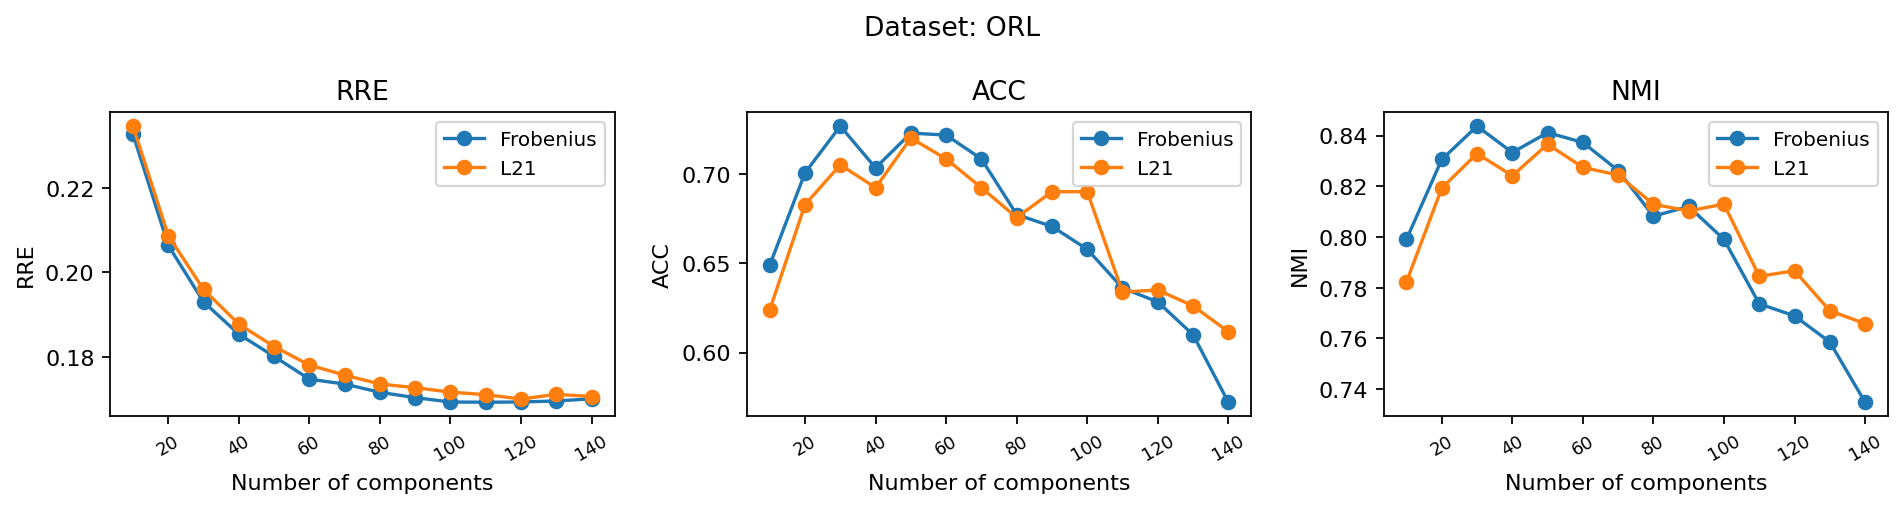

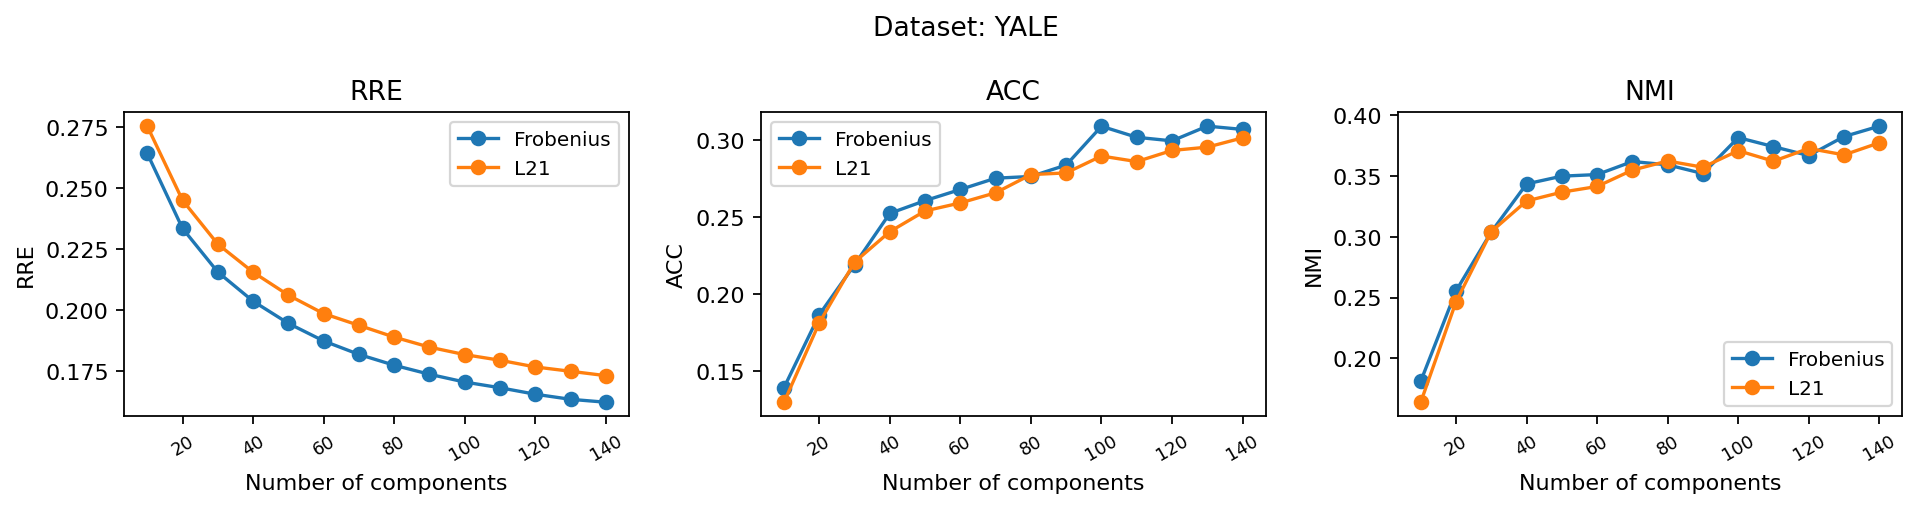

In [152]:
x_label = 'Number of components'
labels = 'k'
plot_results(result_rank, x_label, labels, legend_name=None)

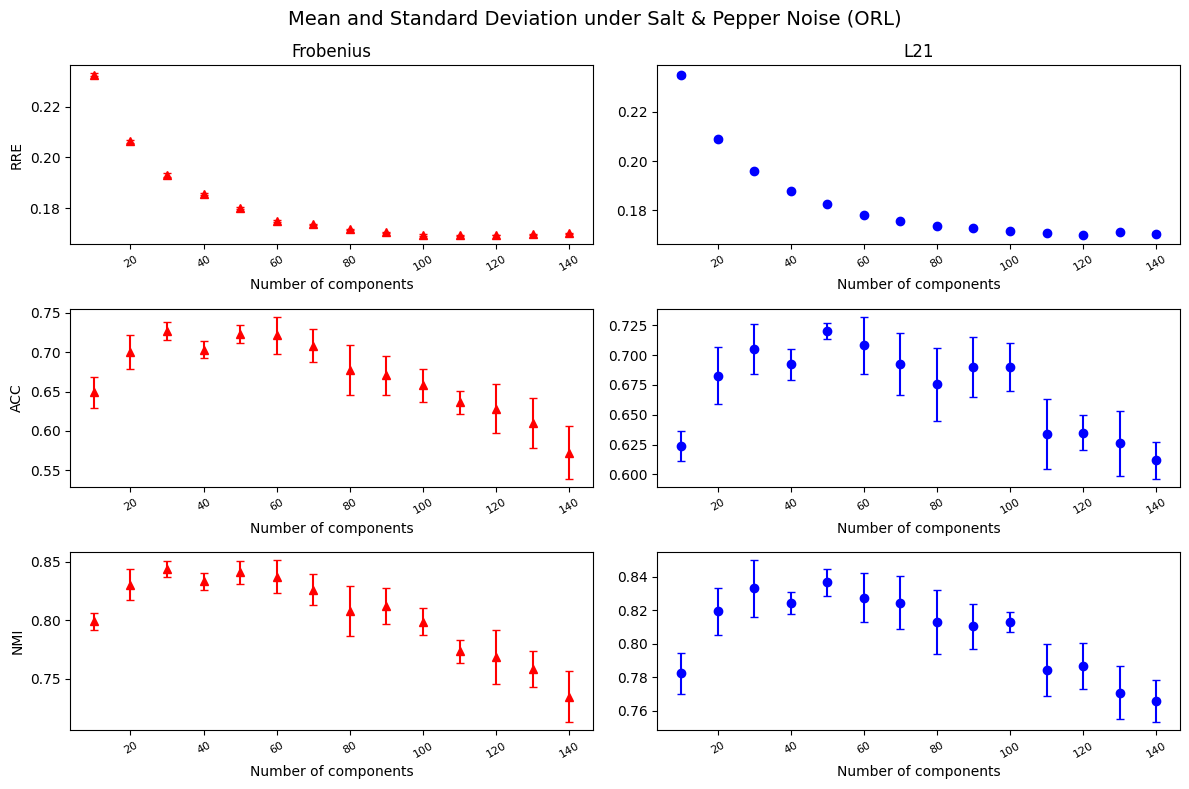

In [153]:
plot_results_deviation(result_rank, x_label, labels, dataset="ORL")

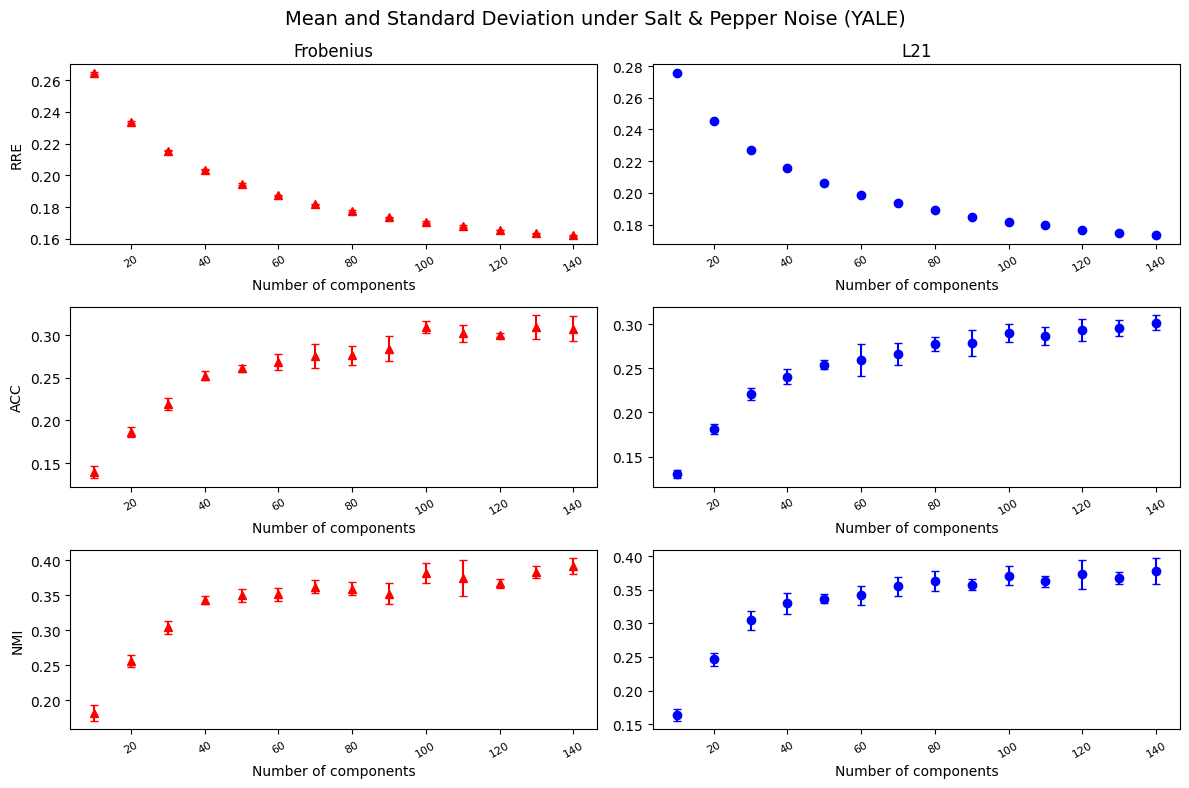

In [154]:
plot_results_deviation(result_rank, x_label, labels, dataset="YALE")

### 3.3 Robustness to noise

In [155]:
def log_experiment(df, filename="experiment_results.txt"):
  """
  Record the experimental result
  """
  mode = "a" if os.path.exists(filename) else "w"
  with open(filename, mode) as f:
      if mode == "w":  # first record
          f.write("===== Experiment Log Start =====\n\n")
      f.write("===== New Experiment =====\n")
      f.write(df.to_string(index=False))
      f.write("\n\n")

In [156]:
# create each cfg
sp_noise_combos = [
    (0.01, 0.5), 
    (0.05, 0.3), 
    (0.1, 0.5),   
    (0.1, 0.7),  
    (0.2, 0.5),   
    (0.3, 0.3),  
    (0.3, 0.7),   
]
configs = []
for m in methods:
    for p, r in sp_noise_combos:
        cfg = {
            **base,
            "dataset": "ORL",
            "nmf_type": m,
            "rank": 50,
            "noise_p": p,
            "noise_r": r,
            "noise_type": "salt_pepper"
        }
        configs.append(cfg)

result_salt_orl = run_configs_parallel(configs, n_jobs=-1, backend="loky", verbose=10)
df = pd.DataFrame(result_salt_orl)
salt_df = df[df["noise_type"] == "salt_pepper"]
log_experiment(salt_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.01
noise_r: 0.5
nmf_type: Frobenius
rank: 50
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.3
nmf_type: Frobenius
rank: 50
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.1
noise_r: 0.5
nmf_type: Frobenius
rank: 50
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.1
noise_r: 0.7
nmf_type: Frobenius
rank: 50
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.2
noise_r: 0.5
nmf_type: Frobenius
rank: 50
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3

[Parallel(n_jobs=-1)]: Done   3 out of  14 | elapsed:   29.4s remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:   36.5s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:   44.7s remaining:   44.7s
[Parallel(n_jobs=-1)]: Done   9 out of  14 | elapsed:   50.7s remaining:   28.1s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:   52.4s remaining:   14.3s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:   56.3s finished


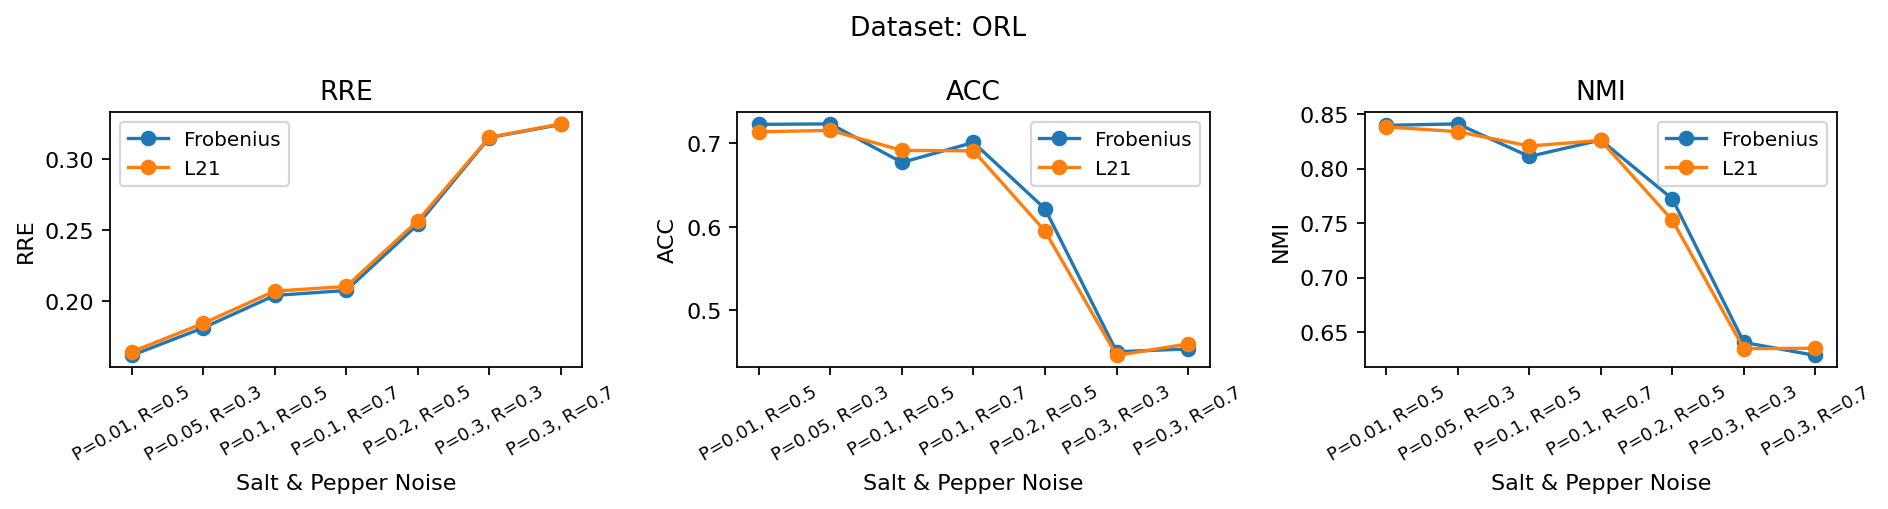

In [157]:
label_names = {'P':'noise_p', 'R':'noise_r'}
x_label = 'Salt & Pepper Noise'
plot_results(result_salt_orl, x_label, label_names)

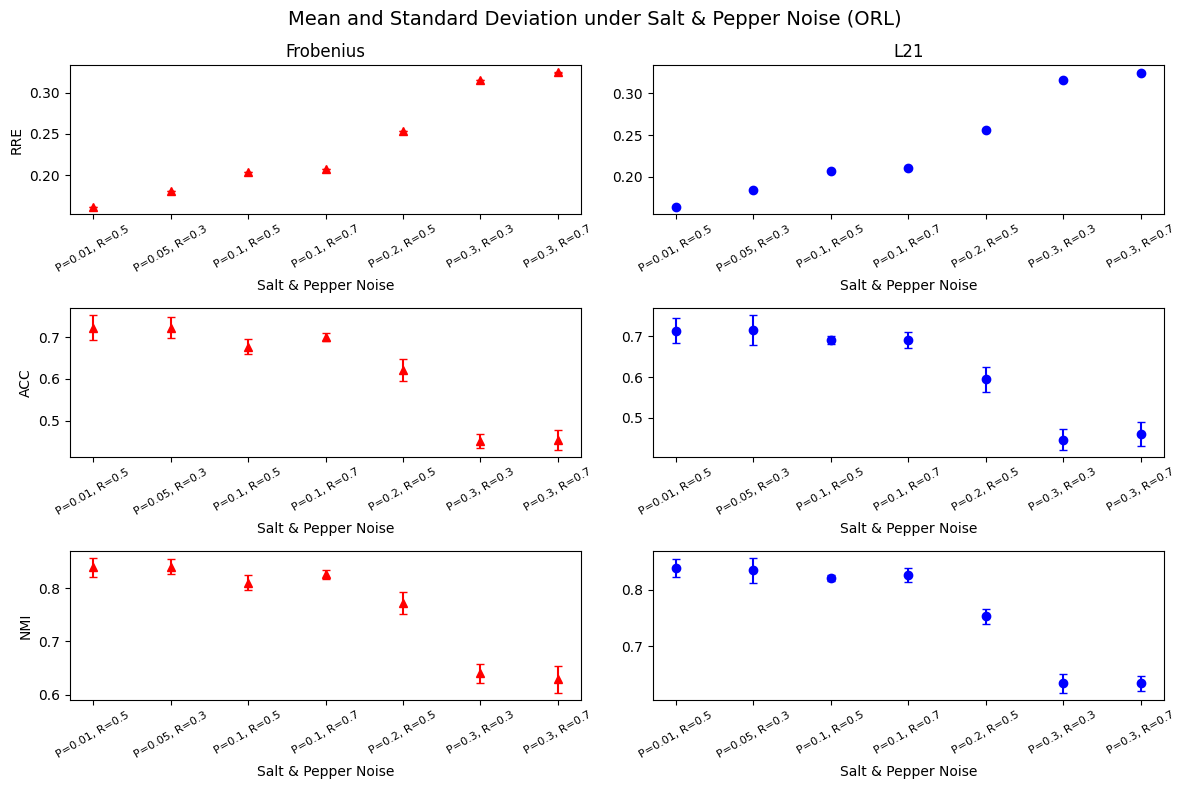

In [158]:
plot_results_deviation(result_salt_orl, x_label, label_names, dataset='ORL')

In [159]:
configs = []
for m in methods:
    for p, r in sp_noise_combos:
        cfg = {
            **base,
            "dataset": "YALE",
            "nmf_type": m,
            "rank": 70,
            "noise_p": p,
            "noise_r": r,
            "max_iterations": 1000,
            "noise_type": "salt_pepper"
        }
        configs.append(cfg)
result_salt_yale = run_configs_parallel(configs, n_jobs=-1, backend="loky", verbose=10)
df = pd.DataFrame(result_salt_yale)
salt_df = df[df["noise_type"] == "salt_pepper"]
log_experiment(salt_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.01
noise_r: 0.5
nmf_type: Frobenius
rank: 70
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.3
nmf_type: Frobenius
rank: 70
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.1
noise_r: 0.5
nmf_type: Frobenius
rank: 70
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.1
noise_r: 0.7
nmf_type: Frobenius
rank: 70
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.2
noise_r: 0.5
nmf_type: Frobenius
rank: 70
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YA

[Parallel(n_jobs=-1)]: Done   3 out of  14 | elapsed:  3.9min remaining: 14.3min
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:  4.5min remaining:  8.2min
[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:  5.0min remaining:  5.0min
[Parallel(n_jobs=-1)]: Done   9 out of  14 | elapsed:  5.5min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:  6.1min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  7.1min finished


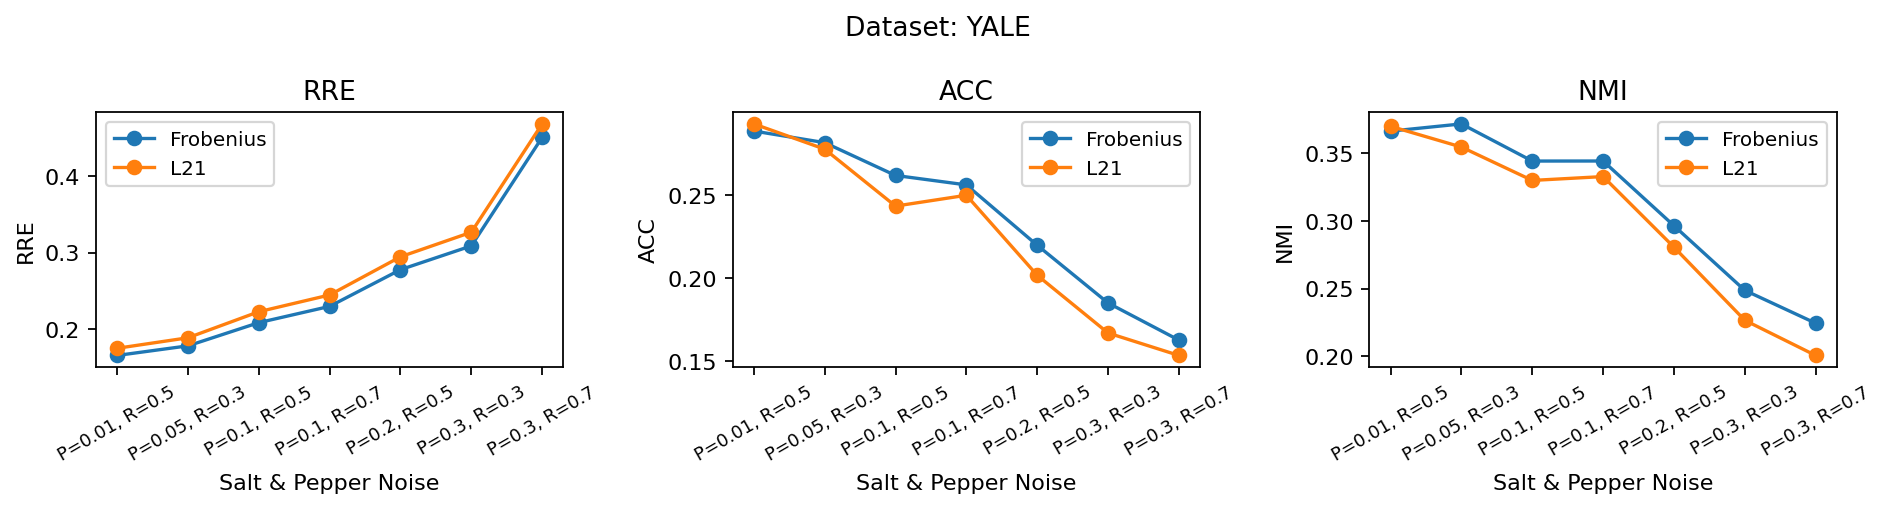

In [160]:
plot_results(result_salt_yale, x_label, label_names)

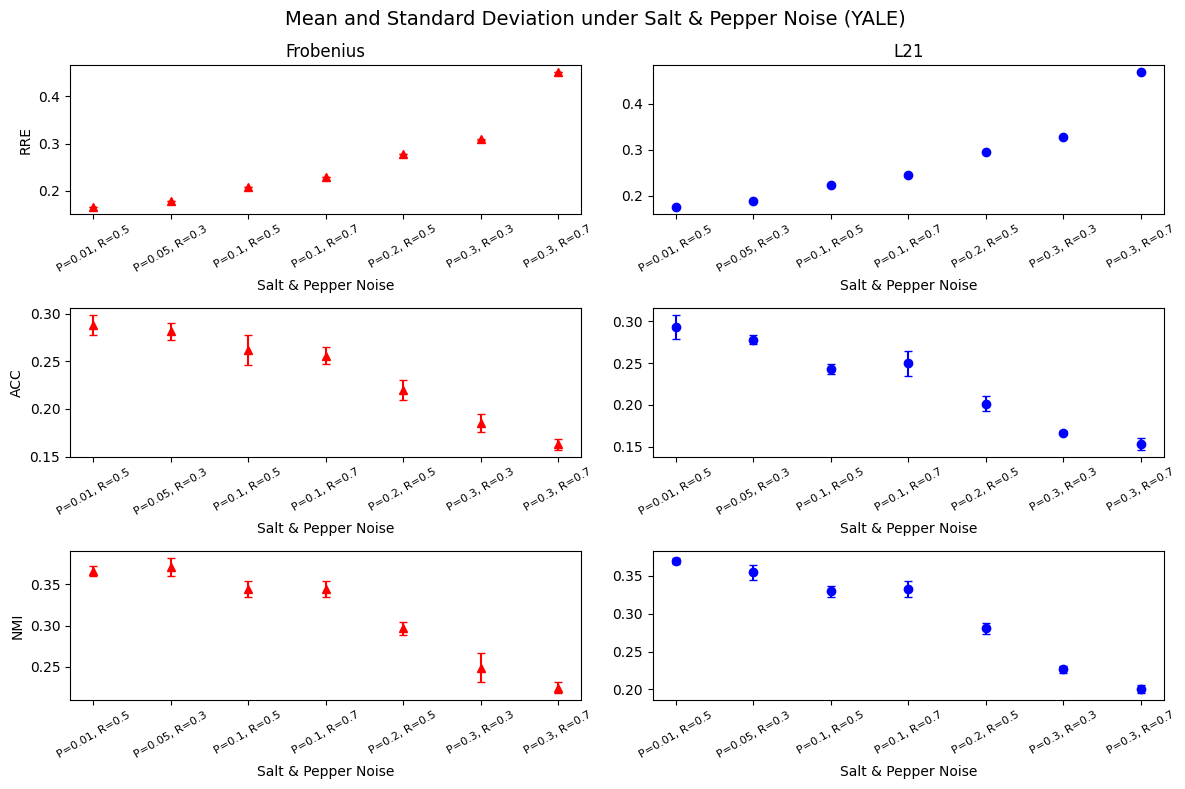

In [161]:
plot_results_deviation(result_salt_yale, x_label, label_names, dataset="YALE")

In [162]:
k_grid   = list(range(10, 141, 10))

# create each cfg
configs = []
for ds in datasets:
    for m in methods:
        for k in k_grid:
            cfg = {**base, "dataset": ds, "nmf_type": m, "rank": k}
            configs.append(cfg)

In [163]:
result_block = run_configs_parallel(configs, n_jobs=-1, backend="loky", verbose=10)
df = pd.DataFrame(result_block)

log_experiment(df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 10
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 20
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 30
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 40
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 50
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.5s


dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 140
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 10
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 20
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 30
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 40
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dat

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   57.1s


dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 60
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 70
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 80
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 90
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 100
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: 

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.9min


dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 20
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 30
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 40
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 50
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 60
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.3min


dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 100
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 110
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 120
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 130
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 140
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
r

[Parallel(n_jobs=-1)]: Done  39 out of  56 | elapsed: 10.2min remaining:  4.5min


dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 90
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 100
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 110
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 120
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 130
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

d

[Parallel(n_jobs=-1)]: Done  45 out of  56 | elapsed: 12.6min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done  51 out of  56 | elapsed: 16.1min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed: 17.9min finished


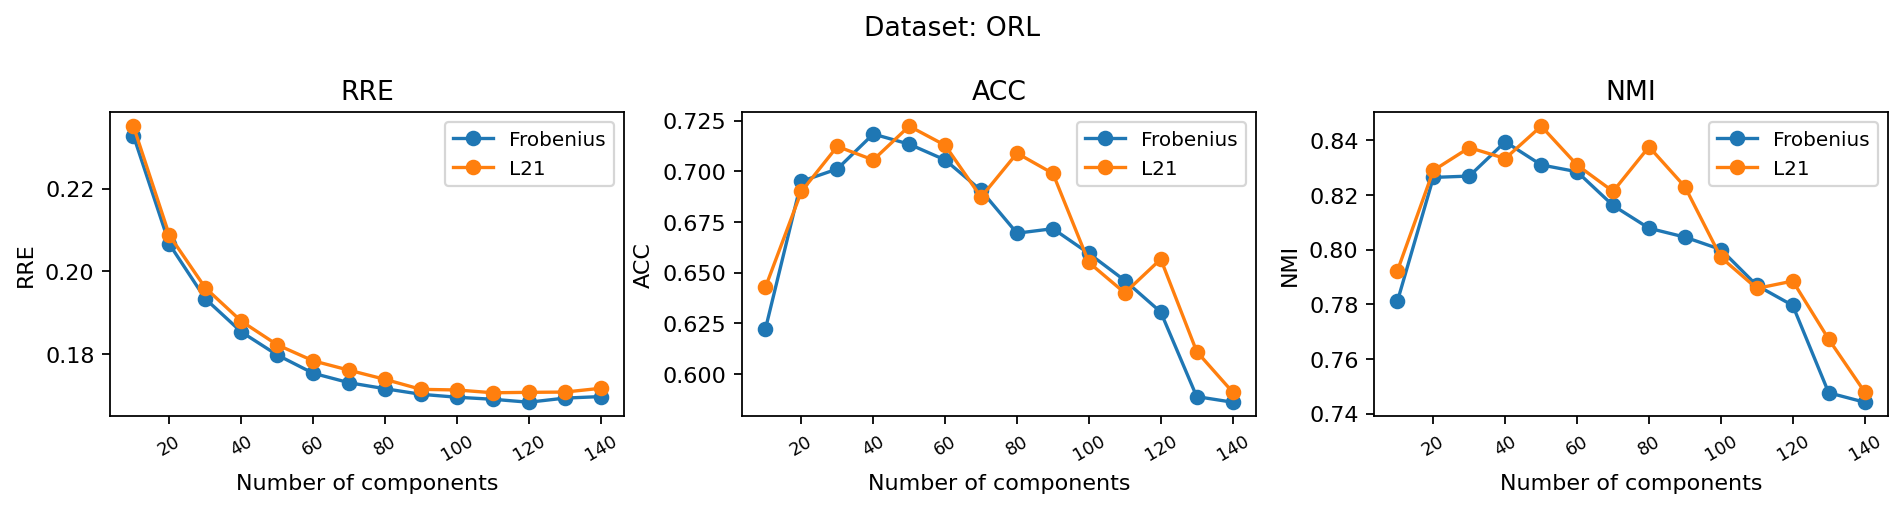

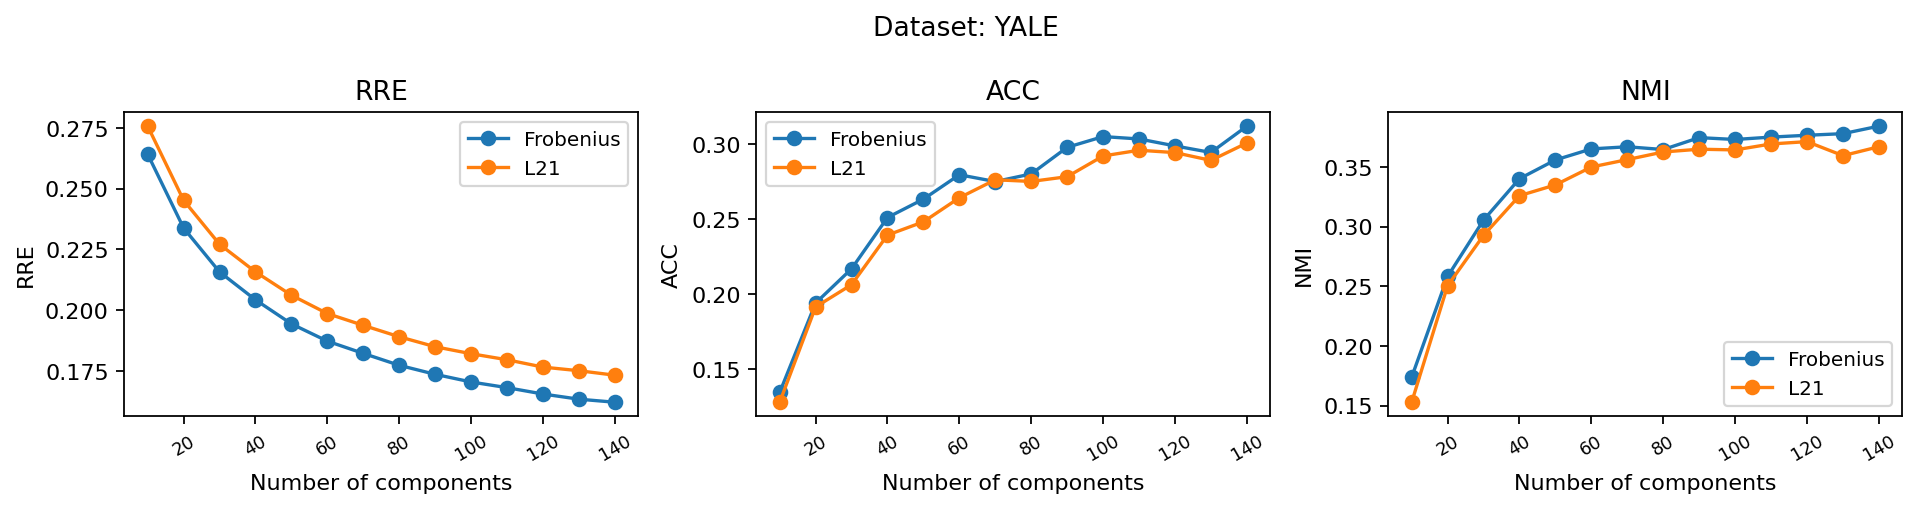

In [164]:
x_label = 'Number of components'
labels = 'k'
plot_results(result_block, x_label, labels, legend_name=None)

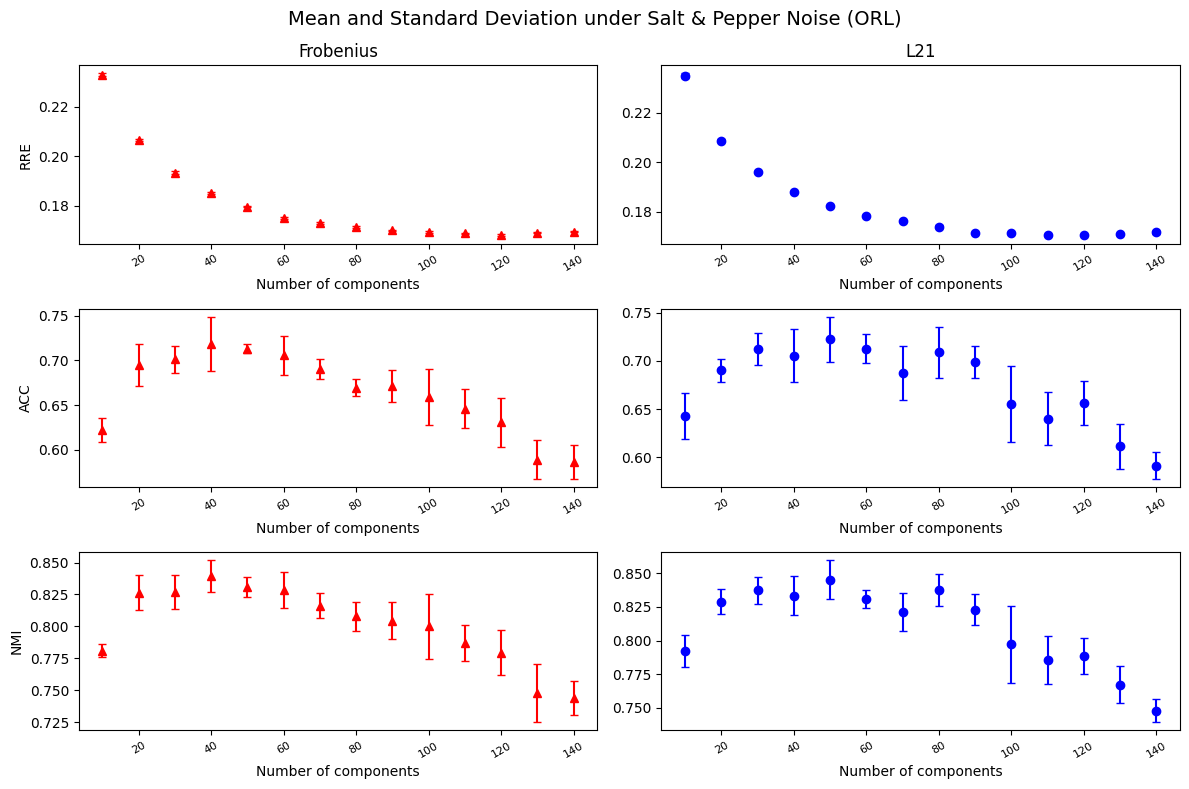

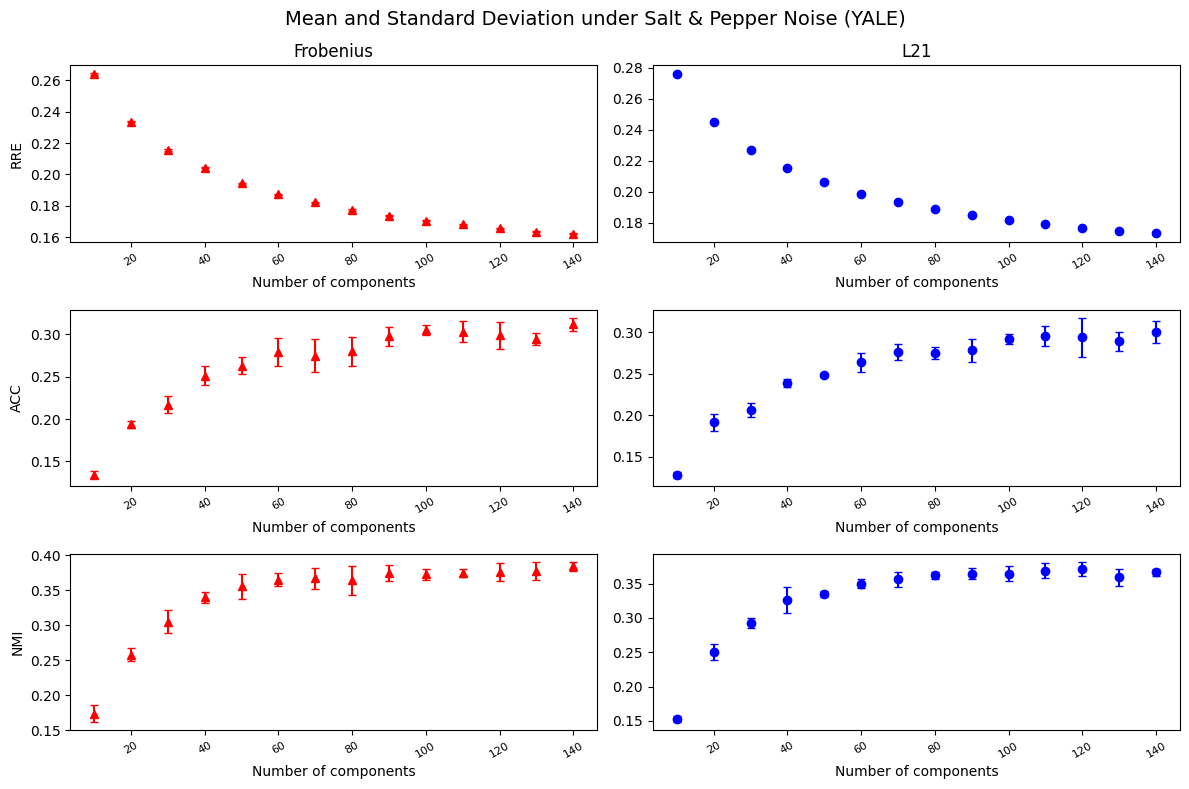

In [165]:
plot_results_deviation(result_block, x_label, labels, dataset="ORL")
plot_results_deviation(result_block, x_label, labels, dataset="YALE")